# jPCA as a constrained LDS



In [1]:
import copy
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import matplotlib.patheffects as pe

import seaborn as sns

import ssm
from scipy.io import loadmat
from sklearn.decomposition import PCA

import importlib
importlib.reload(ssm)

def plot_trajectory(ax, x, y, 
                    color="black",
                    outline="black",
                    circle=True,
                    arrow=True):
    """
    Plot a single neural trajectory in a 2D plane.
    
    Args
    ----
        ax: Axis used for plotting.
        
        x: Values of variable on x-axis.
        
        y: Values of variable on y-axis.
        
        color: Fill color of line to be plotted. Defaults to "black".
        
        outline: Outline color of line. Defaults to "black".
        
        circle: True if the trajectory should have a circle at its starting state.
        
        arrow: True if the trajectory should have an arrow at its ending state.
        
    """
    ax.plot(x, y,
             color=color,
             path_effects=[pe.Stroke(linewidth=2, foreground=outline), pe.Normal()])
        
    if circle:
        circ = plt.Circle((x[0], y[0]),
                          radius=0.05, 
                          facecolor=color,
                          edgecolor="black")
        ax.add_artist(circ)

    if arrow:
        dx = x[-1] - x[-2]
        dy = y[-1] - y[-2]
        px, py = (x[-1], y[-1])
        ax.arrow(px, py , dx, dy, 
                  facecolor=color, 
                  edgecolor=outline,
                  length_includes_head=True,
                  head_width=0.05)

def plot_projections(data_list,
                     x_idx=0,
                     y_idx=1,
                     arrows=True,
                     circles=True,
                     align_prep_state=True):
    """
    Plot trajectories found via jPCA or PCA. 
    
    Args
    ----
        data_list: List of trajectories, where each entry of data_list is an array of size T x D, 
                   where T is the number of time-steps and D is the dimension of the projection.

        x_idx: column of data which will be plotted on x axis. Default 0.

        y_idx: column of data which will be plotted on y axis. Default 0.

        arrows: True to add arrows to the trajectory plot.

        circles: True to add circles at the beginning of each trajectory.

        sort_colors: True to color trajectories based on the starting x coordinate. This mimics
                     the jPCA matlab toolbox.
    """
    fig = plt.figure(figsize=(5,5))
    colormap = plt.cm.RdBu
    colors = np.array([colormap(i) for i in np.linspace(0, 1, len(data_list))])
    data_list = [data[:, [x_idx, y_idx]] for data in data_list]
    basis = np.array([[1, 0], [0,1]])
    
    # Optional: align prep states so that they spread along the horizontal axis.

    prep_states = np.row_stack([data[0] for data in data_list])
    pca = PCA(n_components=2)
    pca = pca.fit(prep_states)
    rot = pca.components_

    pc1 = np.append(rot[:,1], 0)
    pc2 = np.append(rot[:, 0], 0)
    cross = np.cross(pc1, pc2)
    if cross[2] > 0:
        rot[:, 1] = -rot[:, 1]
    basis = basis @ rot

    test_proj = np.concatenate(data_list) @ basis
    if np.max(np.abs(test_proj[:, 1])) > np.max(test_proj[:, 1]):
        basis = -basis

    data_list = data_list @ basis
    # Sort colors left to right bases on prep states position
    # on horizontal axis.
    start_x_list = [data[0,0] for data in data_list]
    color_indices = np.argsort(start_x_list)

    ax = plt.gca()
    for i, data in enumerate(np.array(data_list)[color_indices]):
        plot_trajectory(ax,
                        data[:, 0],
                        data[:, 1],
                        color=colors[i],
                        circle=circles,
                        arrow=arrows)

## Gaussian Emissions

In [14]:
N = 10
D = 4

In [3]:
# Create random rotational LDS
np.random.seed(seed=121)

true_lds = ssm.LDS(N, D, dynamics="gaussian", emissions="gaussian")
true_lds.dynamics.A = 0.99*ssm.util.random_rotation(D, theta=np.pi/13)
true_lds.dynamics.Sigmas = 0.001 * true_lds.dynamics.Sigmas
true_lds.dynamics.bs = np.zeros_like(true_lds.dynamics.bs)
datas = []
xs = []
for i in range(100):
    x, y = true_lds.sample(50)
    xs.append(x)
    datas.append(y)

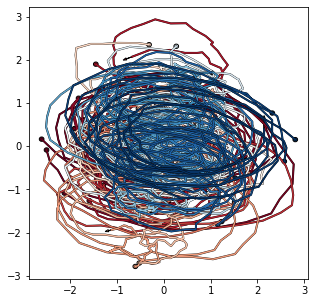

In [4]:
plot_projections(xs)

In [5]:
def real_modal_form(A):
#     import pdb; pdb.set_trace()
    vals, vecs = np.linalg.eig(A)
    
    # sort eigenvalues and vectors by the strength of their imaginary part    
    real_idx = np.abs(np.imag(vals)) < 1e-16
    imag_idx = ~real_idx
    
    real_eigvecs = vecs[:, real_idx]
    imag_eigvals = vals[imag_idx]
    imag_eigvecs = vecs[:, imag_idx]
    
    idx = np.argsort(np.abs(np.imag(imag_eigvals)))[::-1]
    imag_eigvals = imag_eigvals[idx]
    imag_eigvecs = imag_eigvecs[:, idx]
    
    # we need to be consistent about taking the eigenvector with the positive imaginary part.
    S = np.zeros_like(A)
    nreals = sum(real_idx)
    S[:, 0:nreals] = real_eigvecs
    
    for i in range(0, A.shape[0] - nreals, 2):
        S[:, i + nreals] = np.real(imag_eigvecs[:, i])
        if np.imag(imag_eigvals[i]) > 0:
            S[:, i+nreals+1] = np.imag(imag_eigvecs[:, i])
        else:
            S[:, i+nreals+1] = -np.imag(imag_eigvecs[:, i])
    return S

In [6]:
A = true_lds.dynamics.A
S = real_modal_form(A)
np.round(np.linalg.inv(S) @ A @ S, 2)

/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


array([[ 0.99,  0.  ,  0.  , -0.  ],
       [-0.  ,  0.99, -0.  ,  0.  ],
       [-0.  , -0.  ,  0.96,  0.24],
       [-0.  , -0.  , -0.24,  0.96]])

In [7]:
vals, vecs = np.linalg.eig(A)
vecs = vecs[:, [2,1,0,3]]

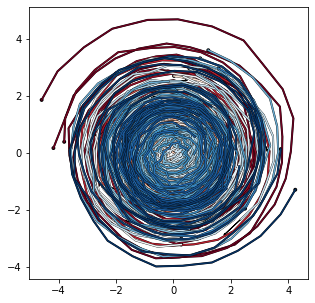

In [8]:
x_tilde = xs @ np.linalg.inv(S).T
plot_projections(x_tilde, x_idx=2, y_idx=3)

Initializing with an ARHMM using 25 steps of EM.


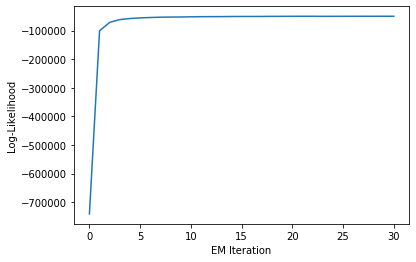

In [10]:
npr.seed(0)

data_list = [Y for Y in datas]
lds = ssm.LDS(N, D, dynamics="rotational", emissions="gaussian")
elbos, posterior = lds.fit(data_list, num_iters=30)
plt.plot(elbos)
plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

In [11]:
A_inf = lds.dynamics.A
S_inf = real_modal_form(A_inf)
x_inf = posterior.mean_continuous_states
x_tilde_inf = x_inf @ np.linalg.inv(S_inf).T

/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


In [12]:
diag = np.linalg.inv(S_inf) @ A_inf @ S_inf

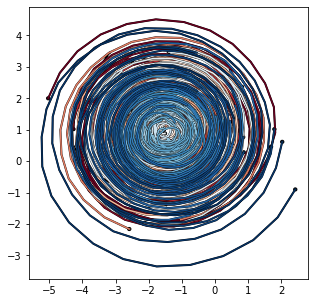

In [13]:
plot_projections(x_tilde_inf, x_idx=0, y_idx=1)

## Poisson Emissions

In [15]:
np.random.seed(seed=121)

true_lds = ssm.LDS(N, D, dynamics="gaussian", emissions="poisson")
true_lds.dynamics.A = 0.99*ssm.util.random_rotation(D, theta=np.pi/13)
true_lds.dynamics.Sigmas = 0.001 * true_lds.dynamics.Sigmas
true_lds.dynamics.bs = np.zeros_like(true_lds.dynamics.bs)
datas = []
xs = []
for i in range(100):
    x, y = true_lds.sample(50)
    xs.append(x)
    datas.append(y)

Initializing with an ARHMM using 25 steps of EM.


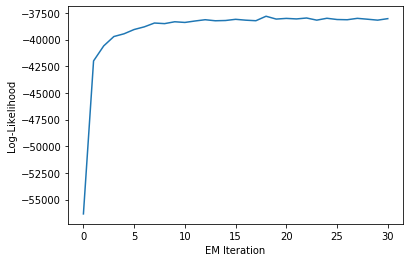

In [16]:
npr.seed(0)

data_list = [Y for Y in datas]
lds = ssm.LDS(N, D, dynamics="rotational", emissions="poisson")
elbos, posterior = lds.fit(data_list, num_iters=30)
plt.plot(elbos)
plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

In [17]:
A_inf = lds.dynamics.A
S_inf = real_modal_form(A_inf)
x_inf = posterior.mean_continuous_states
x_tilde_inf = x_inf @ np.linalg.inv(S_inf).T

/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


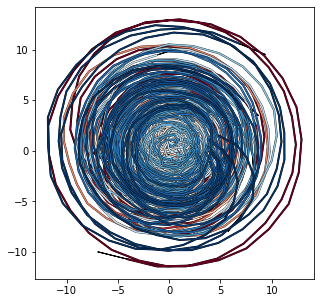

In [18]:
plot_projections(x_tilde_inf, x_idx=0, y_idx=1)